In [10]:
import numpy as np
from pybads.bads import BADS
from pyvbmc import priors
import uuid
import sys
import os
import random
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [11]:
# import model
from models import RLWMmodel

In [12]:
unique_id = str(uuid.uuid4())

In [ ]:
modelSpecs=[
    {   
        "name": "simpleRLWM",
        "settings": {
            "interactionRLWM": False,
        },
        "parameters": {
            "WMforget": "free_prior",
            "WMcapacity": "free_prior",
            "WMweight": "free_prior",
            "WMbias-": "fixed_1",
            "Qlr+": "free_prior",
            "Qlr-": "mirror_Qlr+",
            "stickiness":"free_prior",
            "invTemperature": "free_prior",
            "epsilon": "fixed_0"
        }
    },
    {   
        "name": "onlyRL",
        "settings": {
            "interactionRLWM": False,
        },
        "parameters": {
            "WMforget": "fixed_0",
            "WMcapacity": "fixed_0",
            "WMweight": "fixed_0",
            "WMbias-": "fixed_0",
            "Qlr+": "free_prior",
            "Qlr-": "mirror_Qlr+",
            "stickiness":"free_prior",
            "invTemperature": "free_prior",
            "epsilon": "fixed_0"
        }
    }
]

In [ ]:
#
simdef={
    "nsims": 50,
    "badsOptions":{
    'max_iter':100, 
    'max_fun_evals':200,
    'display': "off",
    }
}

# 
expdef={
    "nrepeats":15,
    "toleranceAvgDistanceRepetition":0.25,
    "feedbackValues": [1,2]
}
#
stimdef={
    "blockTypes":[
        {"setSize": 2,"correctAction": [0,1],"phase": "learn"},
        {"setSize": 2,"correctAction": [1,2],"phase": "learn"},
        {"setSize": 3,"correctAction": [0,1,2],"phase": "learn"},
        {"setSize": 3,"correctAction": [1,1,2],"phase": "learn"},
        {"setSize": 3,"correctAction": [0,0,2],"phase": "learn"},
        {"setSize": 4,"correctAction": [0,1,2,2],"phase": "learn"},   
        {"setSize": 4,"correctAction": [0,1,1,2],"phase": "learn"},    
        {"setSize": 4,"correctAction": [0,0,1,2],"phase": "learn"},
        {"setSize": 5,"correctAction": [0,0,1,2,2],"phase": "learn"},    
        {"setSize": 5,"correctAction": [0,1,1,2,2],"phase": "learn"},
        {"setSize": 5,"correctAction": [0,0,1,1,2],"phase": "learn"},
        {"setSize": 6,"correctAction": [0,0,1,1,2,2],"phase": "learn"},    
        {"setSize": 6,"correctAction": [0,0,1,1,2,2],"phase": "learn"}
    ]
}


In [15]:
# generate trial lists matching the distribution condition
simdef["allTrials"]=[]

for sim in range(simdef["nsims"]):
    sim_blocks=[]
    for blockidx in range(len(stimdef["blockTypes"])):
        block=stimdef["blockTypes"][blockidx]
        spacing_condition=False
        while not spacing_condition:
            try_images = []
            for imgidx in range(block["setSize"]):
                try_images.extend([imgidx] * expdef['nrepeats'])
            # Shuffle the image indices
            random.shuffle(try_images)

            last_seen = {}
            gaps = defaultdict(list)

            for i, imgidx in enumerate(try_images):
                if imgidx in last_seen:
                    gap = i - last_seen[imgidx]
                    gaps[imgidx].append(gap)
                last_seen[imgidx] = i

            spacing_condition = all(
                (sum(gap_list) / len(gap_list)) >= (block['setSize'] - expdef['toleranceAvgDistanceRepetition']) and
                (sum(gap_list) / len(gap_list)) <= (block['setSize'] + expdef['toleranceAvgDistanceRepetition'])
                for gap_list in gaps.values()
            )
        # Build trial array based on valid pseudorandomized image sequence
        block_trials=[]
        for tblock_num, imgidx in enumerate(try_images):
            trial = {
                'correctAction': block['correctAction'][imgidx],
                'correctFeedback': imgidx % 2,
                'setSize': block['setSize'],
                'imgIdx': imgidx,
                'phase': block['phase']
            }
            block_trials.append(trial)        
        random.shuffle(block_trials)
        sim_blocks.append(block_trials)
    random.shuffle(sim_blocks)
    simdef["allTrials"].append(sim_blocks)


In [16]:
priorP=RLWMmodel.getPriors()
listC=[]
simulationP=[]
# now that we have our trial list for every trial, simulate our agents
for midx,modelspec in enumerate(modelSpecs):
    for simidx,blocks in enumerate(simdef["allTrials"]):
        # init agent
        mapP,P,_=RLWMmodel.getMapParams(modelspec, priorP=priorP, priorsFunc=priors, nDraws=1)
        dictP=RLWMmodel.getParamDict(P[0,:],mapP)
        for blockidx,blocktrials in enumerate(blocks):
            # init latent states for this block
            setSize=blocktrials[0]["setSize"]
            repeatImg=np.zeros((setSize))
            X,mapX=RLWMmodel.initX(setSize=setSize)
            for trialidx, trial in enumerate(blocktrials):
                # context of this trial
                repeatImg[trial["imgIdx"]]+=1
                C={"S": trial["imgIdx"],"setSize": setSize,"midx":midx,"simidx":simidx,"blockidx":blockidx,"imgRepeat":repeatImg[trial["imgIdx"]], "modelName":modelspec["name"]}
                # act
                policy,logLik=RLWMmodel.act(X,dictP=dictP,mapX=mapX,C=C,settings=modelspec["settings"])
                C["A"]=np.random.choice(3,p=policy)
                # get reward if any
                if C["A"]==trial["correctAction"]:
                    C["correct"]=1
                    C["R"]=expdef["feedbackValues"][trial["correctFeedback"]]
                else:
                    C["R"]=0
                    C["correct"]=0
                # update model
                X=RLWMmodel.update(X,dictP=dictP,mapX=mapX,C=C,settings=modelspec["settings"])
                # augment context and log
                C = C | dictP
                listC.append(C)      

dfC=pd.DataFrame(listC)



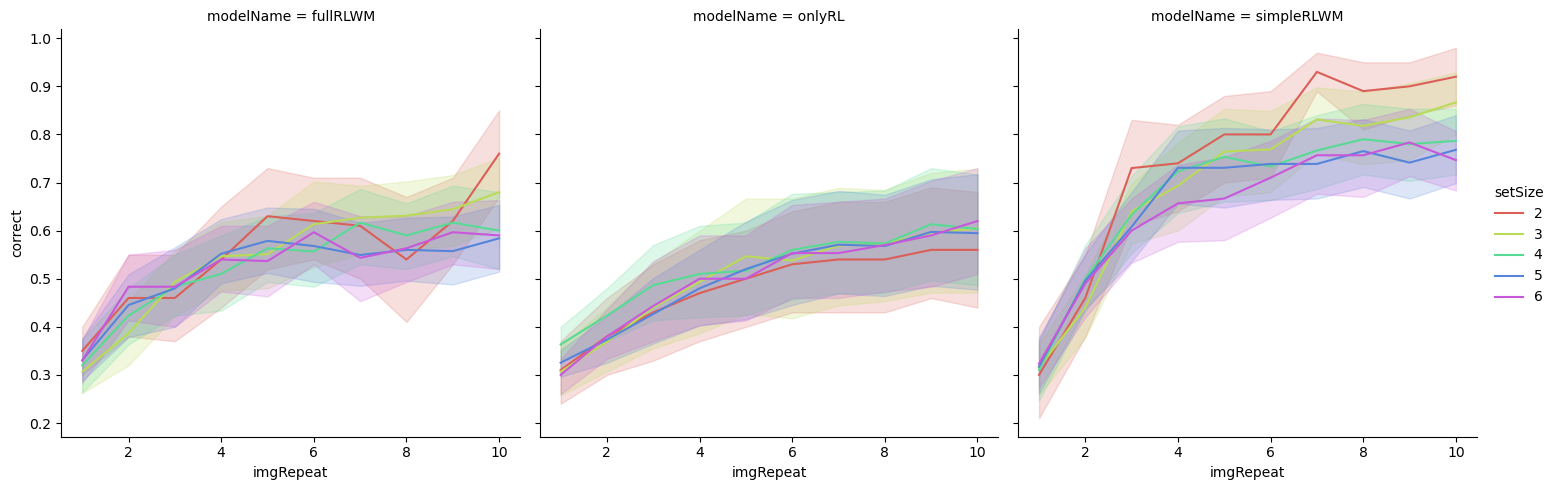

In [20]:
df_summary = (
    dfC.groupby(['imgRepeat', 'setSize', 'simidx','modelName'])['correct']
    .mean()
    .reset_index()
)

# Plot with seaborn relplot
sns.relplot(
    data=df_summary,
    x='imgRepeat',
    y='correct',
    hue='setSize',
    kind='line',
    col="modelName",
    palette=sns.color_palette("hls", 5)
)


In [18]:
if False:
    # Now, let's fit the data that we've just simulated with each model, using each model
    listDictFitResult=[]
    listDictSim=[]
    total_iters = len(modelSpecs) * len(modelSpecs) * len(simdef["allTrials"])
    with tqdm(total=total_iters, desc="Fitting models") as pbar:
        for fitmidx,fitmodelspec in enumerate(modelSpecs):
            # get bounds 
            mapP,_,boundsP=RLWMmodel.getMapParams(fitmodelspec, priorP=priorP, priorsFunc=priors, nDraws=1)
            boundsPmat=np.array(boundsP)
            for midx,modelspec in enumerate(modelSpecs):
                for simidx,blocks in enumerate(simdef["allTrials"]):
                    simInfo=dfC.loc[((dfC["midx"]==midx) & (dfC["simidx"]==simidx)),mapP.keys()].reset_index(drop=True).loc[0,:].to_dict()
                    mapP,startP,_=RLWMmodel.getMapParams(fitmodelspec, priorP=priorP, priorsFunc=priors, nDraws=1)
                    # create the  likelihood function to minimize
                    def fitfunc(P):
                        dictP=RLWMmodel.getParamDict(P,mapP)
                        sumNLL=0
                        for blockidx,blocktrials in enumerate(blocks):
                            setSize=blocktrials[0]["setSize"]
                            X,mapX=RLWMmodel.initX(setSize=setSize)
                            simC=dfC.loc[((dfC["midx"]==midx) & (dfC["simidx"]==simidx) & (dfC["blockidx"]==blockidx)),["S","A","R","setSize"]].reset_index(drop=True)
                            for trialidx, trial in simC.iterrows():
                                C=simC.reset_index(drop=True).loc[trialidx,:].to_dict()
                                _,logLik=RLWMmodel.act(X,dictP=dictP,mapX=mapX,C=C,settings=fitmodelspec["settings"])
                                X=RLWMmodel.update(X,dictP=dictP,mapX=mapX,C=C,settings=modelspec["settings"])
                                sumNLL-=logLik
                        return sumNLL
                    #                  
                    bads = BADS(fitfunc, startP[0,:], boundsPmat[:,0], boundsPmat[:,3], boundsPmat[:,1], boundsPmat[:,2], options=simdef["badsOptions"])
                    optimize_result = bads.optimize()
                    fitted = np.array(optimize_result['x'])
                    dictFitResult=RLWMmodel.getParamDict(fitted,mapP)
                    nll = optimize_result['fval']
                    dictFitResult["nll"]=nll
                    listDictFitResult.append(dictFitResult)
                    listDictSim.append(simInfo)
                    pbar.update(1)
